# Spotify Song Prediction

In [35]:
from google.colab import files
uploaded = files.upload()

Saving data_by_artist.csv to data_by_artist.csv


In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model  # will be using for plotting trend line
from sklearn.preprocessing import MinMaxScaler # for normalizing data
from sklearn.cluster import KMeans 
%matplotlib inline

In [43]:
spotify = pd.read_csv('data.csv')

In [44]:
spotify.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


In [16]:
spotify.isnull().sum()

acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
valence             0
year                0
dtype: int64

### Basic EDA

In [17]:
# removing waste stuff(square bracket and quotation marks) from artist's name 
spotify['artists'] = spotify['artists'].apply(lambda x: x[1:-1].replace("'", ''))
# correcting data types 
spotify['release_date'] = pd.to_datetime(spotify['release_date'])
# spotify['year'] = pd.to_datetime(spotify['year'].apply(lambda x: str(x)+'-01-01'))

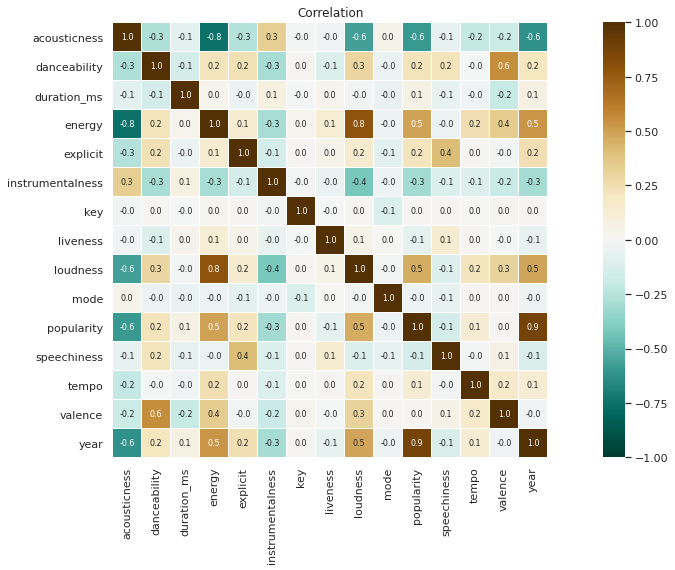

In [18]:
# finding correlation
corr = spotify.corr()
# visualizing correlaiton with heatmap
plt.figure(figsize=(20,8))
sns.heatmap(corr, vmax=1, vmin=-1, center=0,linewidth=.5,square=True, annot = True, annot_kws = {'size':8},fmt='.1f', cmap='BrBG_r')
plt.title('Correlation')
plt.show()

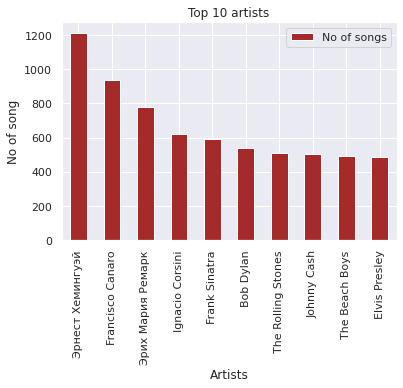

In [19]:
# lets see top10 artists who sang more songs than others
Top10 = pd.DataFrame({'No of songs':spotify['artists'].value_counts().head(10)})
Top10.plot.bar(color='brown')
plt.title('Top 10 artists')
plt.xlabel('Artists')
plt.ylabel('No of song')
plt.show()

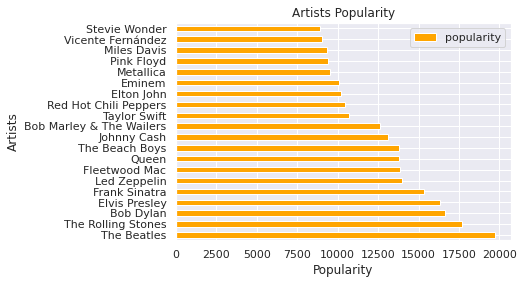

In [20]:
# lets analyze artists whose songs are too popular
# spotify[['artists', 'name', 'popularity']].sort_values(by=['popularity'], ascending =False)
artists_grp = spotify.groupby(['artists'])
Top20artists = artists_grp[['popularity']].sum().sort_values(by=['popularity'], ascending=False)[:20]
Top20artists.plot.barh(color='orange')
plt.title('Artists Popularity')
plt.xlabel('Popularity')
plt.ylabel('Artists')
plt.show()

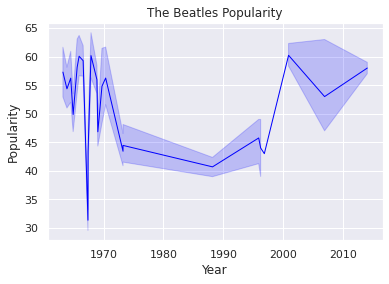

In [21]:
# lets analyze the popularity of The Beatles songs over the year
Beatles = spotify[spotify['artists'] == 'The Beatles']
# grid
sns.set(style='darkgrid')
# line plot passing x,y
sns.lineplot(x='release_date', y='popularity',lw = 1, data=Beatles, color='blue')
# Labels
plt.title("The Beatles Popularity")
plt.xlabel('Year')
plt.ylabel('Popularity')
plt.show()

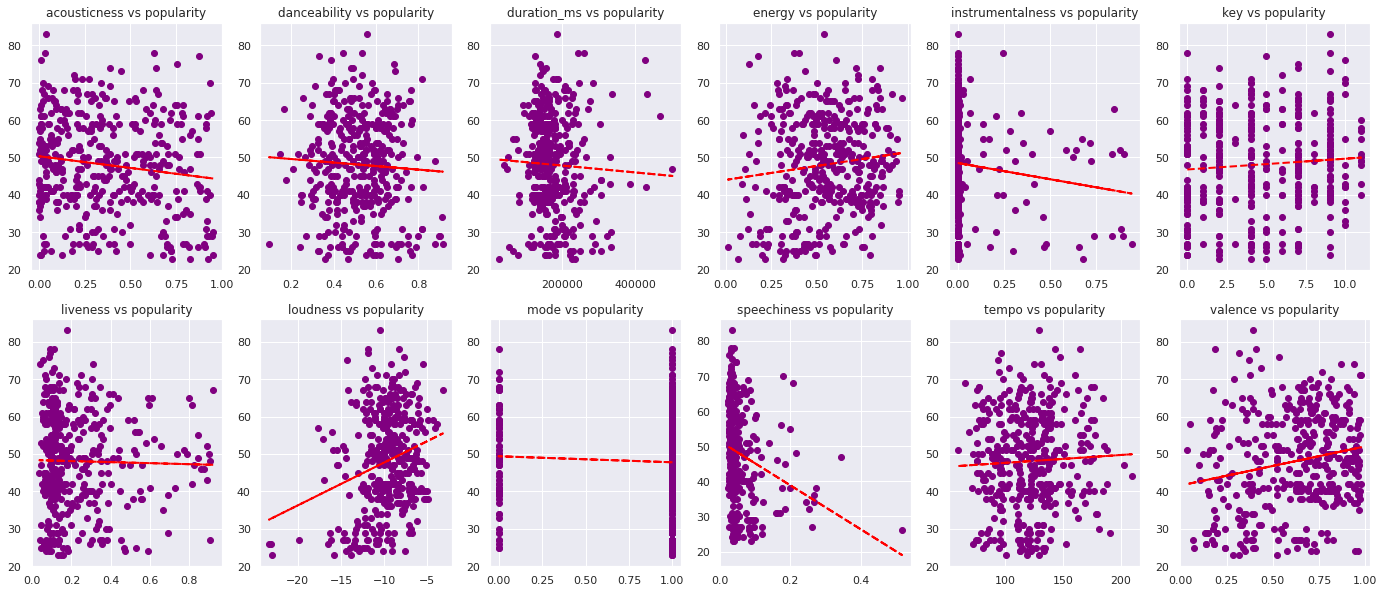

In [22]:
# so now lets analyze which features of songs is affecting popularity in Beatles songs
plt.figure(0, figsize=(24,10))
x_axis = ['acousticness','danceability', 'duration_ms', 'energy', 'instrumentalness',
          'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence']
z = 0
for i in range(2):
    for j in range(6):
        # values to be plotted on axis(x,y)
        x = Beatles[x_axis[z]].values.reshape(-1,1)
        y = Beatles["popularity"].values.reshape(-1,1)
        # linear model 
        regr = linear_model.LinearRegression()
        regr.fit(x, y)
        # sub-plot
        ax = plt.subplot2grid((2,6),(i,j))
        ax.scatter(x,y, c='purple')
        # adding trend line
        ax.plot(x, regr.predict(x), color="red", linewidth=2, linestyle='--')
        # adding title
        ax.title.set_text(f'{x_axis[z]} vs popularity')
        z += 1
plt.show()

### Perform time-series analysis

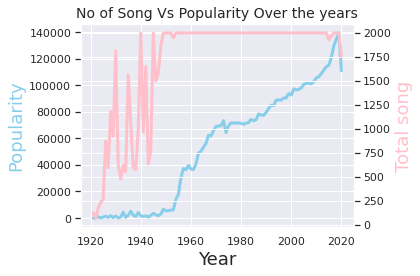

In [23]:
# lets analyze the increasing listener over the year
year_grp = spotify.groupby(['year'], as_index=False)
popularity_track = year_grp[['name', 'popularity']].sum()
song_count = year_grp['name'].count()

# dual axis graph
fig, ax1 = plt.subplots()
# Popularity of songs
ax1.plot(popularity_track.year, popularity_track.popularity, color='skyblue', linewidth=3,)
ax1.set_title('No of Song Vs Popularity Over the years', fontsize=14)
ax1.set_xlabel('Year', fontsize=18)
ax1.set_ylabel('Popularity', color='skyblue', fontsize=18)
# Adding second axis to the graph
ax2 = ax1.twinx()
# No of songs 
ax2.plot(song_count.year, song_count.name, color='pink', linewidth=3)
ax2.set_ylabel('Total song', color='pink', fontsize=18)
fig.tight_layout()
plt.show()

In [24]:
# lets see the increase of artists over the year
artists_data = {}
# Avoid duplicates
added = []
for year in spotify['year'].unique():
    # temporary container 
    total_artist = []
    for artist in spotify[spotify.year == year]['artists'].unique():
        if artist not in added:
            total_artist.append(artist)
    artists_data[year] = len(total_artist)
    added.extend(total_artist)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


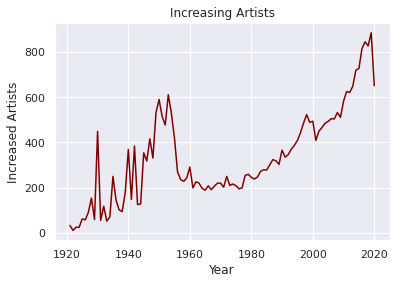

In [25]:
# creating dataframe 
artists_record = pd.DataFrame({'Year': list(artists_data.keys()),
                              'Increased_artists': list(artists_data.values())})
# line plot 
sns.lineplot('Year', 'Increased_artists', color='maroon', data=artists_record)
plt.title('Increasing Artists')
plt.xlabel('Year')
plt.ylabel('Increased Artists')
plt.show()

### Differentiate genres

In [27]:
# lets perform clustering
# data(columns) we will we using
song_features = pd.DataFrame()
# normalizer instance
scaler = MinMaxScaler()
for col in spotify.iloc[:,:-1].columns:      # excluding year col i.e, of int64 type
    if spotify[col].dtypes in ['float64', 'int64']:
        # adding normalized col
        scaler.fit(spotify[[col]])
        song_features[col] = scaler.transform(spotify[col].values.reshape(-1,1)).ravel()  

In [29]:
# first we would like to know that how many cluster or to say Genres can be clustered 
# with less SSE(Sum of Squared Error) we will use "Elbow method" to find out 

# KMeans instance
km = KMeans()
k_rng = range(1,200)  # k value
sse = [] # sse value for each k
for i in k_rng:
    km = KMeans(n_clusters = i)
    km.fit(song_features.sample(1000))
    # calculating sse
    sse.append(km.inertia_) 
    
# due to less computation power I am unable to use whole data 
# I guess 1000 sample of whole data can depict actual

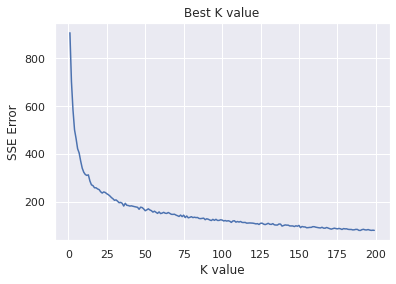

In [30]:
plt.plot(k_rng,sse)
plt.xlabel('K value')
plt.ylabel('SSE Error')
plt.title('Best K value')
# plt.ylim(0,400)
# plt.xlim(0,100)
plt.show()

In [31]:
# looks like 25 is good value of K
km = KMeans(n_clusters=25)
predicted_genres = km.fit_predict(song_features)

In [32]:
song_features['predicted_genres'] = predicted_genres
song_features['predicted_genres'] = song_features['predicted_genres'].apply(lambda x: 'Genre'+ str(x))

In [33]:
song_features.sample(10)

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,predicted_genres
63889,0.996988,0.627530,0.036660,0.2610,0.0,0.001600,0.818182,0.2090,0.772892,0.0,0.00,0.589267,0.301883,0.5820,Genre20
53956,0.890562,0.465587,0.029517,0.4550,0.0,0.001320,0.363636,0.1020,0.800893,0.0,0.39,0.030031,0.602759,0.4400,Genre4
2345,0.881526,0.347166,0.063233,0.2170,0.0,0.005140,0.000000,0.0802,0.678866,1.0,0.16,0.031579,0.294779,0.2770,Genre1
7819,0.375502,0.492915,0.031673,0.6250,0.0,0.000000,0.727273,0.2260,0.859572,1.0,0.67,0.041383,0.698088,0.3510,Genre16
8987,0.990964,0.564777,0.043067,0.1400,0.0,0.913000,0.272727,0.1410,0.602239,1.0,0.01,0.047265,0.471115,0.1570,Genre22
161235,0.182731,0.870445,0.046263,0.4000,0.0,0.000003,0.181818,0.0581,0.827954,1.0,0.72,0.055521,0.532281,0.8130,Genre3
35203,0.587349,0.546559,0.043549,0.4780,0.0,0.000002,0.454545,0.0804,0.761632,1.0,0.24,0.028070,0.521564,0.7990,Genre19
99901,0.835341,0.180162,0.125701,0.0301,0.0,0.889000,0.909091,0.1050,0.444194,1.0,0.00,0.041486,0.470210,0.1530,Genre2
80160,0.710843,0.498988,0.029618,0.2270,0.0,0.535000,0.454545,0.6320,0.750873,0.0,0.12,0.061094,0.690066,0.7390,Genre12
137480,0.997992,0.500000,0.035906,0.0633,0.0,0.905000,1.000000,0.0978,0.641751,0.0,0.00,0.065635,0.413121,0.0511,Genre21


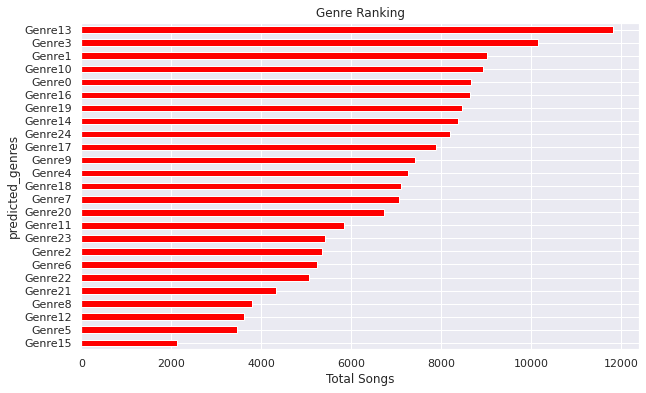

In [34]:
# lets see how many songs falls in each Genre and which Genre have more songs
genres_grp = song_features.groupby(['predicted_genres']).size()
plt.figure(figsize=(10,6))
genres_grp.sort_values(ascending=True).plot.barh(color='red')
plt.xlabel('Total Songs')
plt.title('Genre Ranking')
plt.show()


### Recommend artists

In [36]:
artists_df = pd.read_csv('data_by_artist.csv')
artists_df = artists_df.rename(columns={"count": "playCount"})

In [37]:
# we will replace each feature with its Genre for our convience and for easy tracking
artists_df.iloc[:,1:-1] = scaler.fit_transform(artists_df.iloc[:,1:-1])
km = KMeans(n_clusters=25)
artists_df['genres'] = km.fit_predict(artists_df.iloc[:,1:-1])
artists_df = artists_df.iloc[:,[0,-3,-2,-1]]
artists_df.head()

,artists,mode,playCount,genres
0,"""Cats"" 1981 Original London Cast",1.0,12,17
1,"""Cats"" 1983 Broadway Cast",1.0,26,17
2,"""Fiddler On The Roof” Motion Picture Chorus",1.0,7,13
3,"""Fiddler On The Roof” Motion Picture Orchestra",1.0,27,13
4,"""Joseph And The Amazing Technicolor Dreamcoat""...",1.0,9,17


In [38]:
# lets create our own user list with his rating and add to artists data
artists_df['user_id'] = np.random.randint(1000,1400,len(artists_df))
artists_df['rating'] = np.random.randint(1,6,len(artists_df))
artists_df.head()

,artists,mode,playCount,genres,user_id,rating
0,"""Cats"" 1981 Original London Cast",1.0,12,17,1142,3
1,"""Cats"" 1983 Broadway Cast",1.0,26,17,1269,3
2,"""Fiddler On The Roof” Motion Picture Chorus",1.0,7,13,1229,4
3,"""Fiddler On The Roof” Motion Picture Orchestra",1.0,27,13,1072,5
4,"""Joseph And The Amazing Technicolor Dreamcoat""...",1.0,9,17,1064,1


In [39]:
# lets create our recommender system
def recommend_me(user):
    """This function will recommend artists to any user with its genre profile"""
    # first we will choose user top liked genres
    fav_genre = artists_df[artists_df['user_id']==user].sort_values(by=['rating','playCount'], ascending=False)['genres'][:5]
    fav_genre = list(dict.fromkeys(fav_genre)) # removing duplicate if exits
    
    # lets clear out the artists from list whose songs has been listened by the user
    listened_artist = artists_df.index[artists_df['artists'].isin(['Johann Sebastian Bach','Frédéric Chopin'])].tolist()
    
    # rest data
    remaining_artist = artists_df.drop(listened_artist, axis=0)
    CanBeRecommened =  remaining_artist[remaining_artist['genres'].isin(fav_genre)]
    
    # now lets sort our artists whose are popular in this user favorite genre
    CanBeRecommened = CanBeRecommened.sort_values(by=['rating','playCount',], ascending=False)[['artists', 'genres', 'rating', 'playCount']][:5]
    
    # output will contain artists name, genres, other useres rating and song played count
    return CanBeRecommened

In [40]:
# lets recommend this user some artists
recommend_me(1012)

,artists,genres,rating,playCount
4393,Chris Brown,5,5,235
4492,Christoph Waltz,5,5,218
1416,Antônio Carlos Jobim,18,5,212
16976,Muddy Waters,18,5,193
22119,Sonny Boy Williamson I,21,5,186


In [41]:
# lets check which genre is user fav and did he get same recommended
artists_df[artists_df.user_id==1012].sort_values(by='rating')['genres'].unique()

array([ 5,  0,  1,  7,  9,  4,  6, 24, 19, 10, 17, 21, 16,  3, 14, 18, 12,
       20, 22,  8, 23], dtype=int32)

In [42]:
# here we can see that user fav genres include 13,7 and 14 and we recommended that too